In [1]:
%load_ext cudf.pandas

In [19]:
%reload_ext cudf.pandas

# <center>**<u>Sampling with Python</u>**</center>

##### __IMPORTS AND DATA PREP FOR NOTEBOOK__

In [2]:
# BASIC IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# GPU OPTIMIZATIONS
import cudf
import jax.numpy as jnp
import pyarrow as pa
import os


In [9]:
# HELPER FUNCTION: FEATHER TO PARQUET CONVERTER
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.feather_to_parquet import main
main()

Required package "pyarrow" was found.
Proceeding with file conversion
File conversion complete.


In [7]:
attrition_df = cudf.read_parquet('~/000_Duckspace/Learning/DataScience/Python_DataScience_Examples/data/sampling/attrition.parquet')

RuntimeError: copy_if failed on 1st step: cudaErrorInvalidDevice: invalid device ordinal

---
# <u>Section 00</u>: **__Sampling Methods__**

---

## **Simple Random Sampling**

---
- Simple Random Sampling (SRS) involves picking rows at random, one at a time, where each row has the same chance of being picked as any other

---

### &nbsp;&nbsp;&nbsp;&nbsp; •**Exercise**

---
- Sample `69` rows from `attrition_df` using _SRS_
- Set the seed to `2025`
- Print the results

In [4]:
attrition_sample = attrition_df.sample(n=69, random_state=2025)
print(attrition_sample)

      Age  Attrition     BusinessTravel  DailyRate            Department  \
462    29        0.0      Travel_Rarely        144                 Sales   
794    32        0.0  Travel_Frequently        430  Research_Development   
14     27        0.0      Travel_Rarely       1240  Research_Development   
1425   52        0.0      Travel_Rarely       1490  Research_Development   
194    22        1.0      Travel_Rarely        617  Research_Development   
...   ...        ...                ...        ...                   ...   
733    38        0.0  Travel_Frequently        653  Research_Development   
1344   54        0.0      Travel_Rarely        821  Research_Development   
237    28        0.0      Travel_Rarely        440  Research_Development   
90     33        0.0         Non-Travel       1313  Research_Development   
24     19        1.0      Travel_Rarely        303  Research_Development   

      DistanceFromHome      Education EducationField EnvironmentSatisfaction  \
462    

- Sweet sample!

---

## **Systematic (Simple) Sampling**

---
- One sampling method that avoids randomness is called systematic sampling. This is done by selecting  rows from the population at regular intervals

---

### &nbsp;&nbsp;&nbsp;&nbsp; •**Exercise**

---
- Create a variable called `sample_size` and set it to `69`
- Calculate the total number of employees making up the full population and save to `pop_size`
- Calculate the interval between selections necessary to select exactly the `sample_size` from the total population where the interval of rows between each selection is the same and save to `interval`
- Systematically sample `69` employees/rows from the population of `attrition_df` and save to `attrition_systematic_sample`
- Print the results

In [5]:
sample_size = 69
pop_size = len(attrition_df)
interval = pop_size // sample_size
attrition_systematic_sample = attrition_df[::interval]
print(attrition_systematic_sample)

      Age  Attrition BusinessTravel  DailyRate            Department  \
0      21        0.0  Travel_Rarely        391  Research_Development   
21     19        0.0  Travel_Rarely       1181  Research_Development   
42     45        0.0  Travel_Rarely        252  Research_Development   
63     23        0.0  Travel_Rarely        373  Research_Development   
84     30        1.0  Travel_Rarely        945                 Sales   
...   ...        ...            ...        ...                   ...   
1365   48        0.0  Travel_Rarely        715  Research_Development   
1386   48        0.0  Travel_Rarely       1355  Research_Development   
1407   50        0.0  Travel_Rarely        989  Research_Development   
1428   50        0.0     Non-Travel        881  Research_Development   
1449   52        0.0  Travel_Rarely        699  Research_Development   

      DistanceFromHome      Education EducationField EnvironmentSatisfaction  \
0                   15        College  Life_Sciences   

---
- Unfortunately, there is an unforeseen problem with out method, though it may have seemed a decent methond at first
- The problem is that if the data is sorted in any particular way, or if the rows have been ordered according to some pattern, the systematic sample may not be representative of the whole population

---
- To see this, add an index to `attrition_df`, assigning this to `attrition_df_id`, then create a scatter plot with`attrition_df_id`, using the column `YearsAtCompany`(as the y) versus the `index` column (as the x)
- Next shuffle the rows of `attrition_df` randomly by calling sample on it and setting `frac=1` (which samples 100% of the population), then reset the row indexes and create an `index` column, assigning this to `attrition_shuffled`
- Create a scatterplot with `attrition_shuffled` in the same way as with `attrition_df_id`
- Plot both of the histograms, compare the two, and see if you can notice why our systematic sampling could be flawed

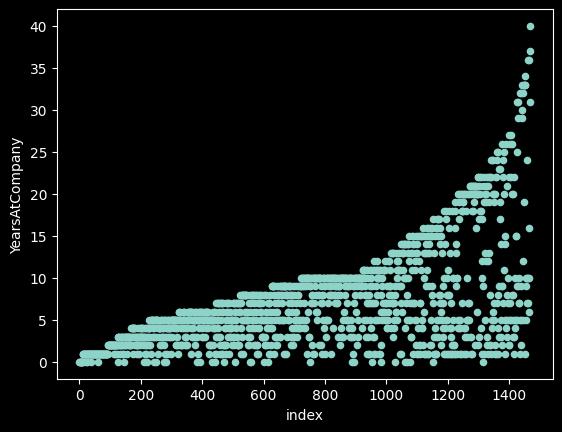

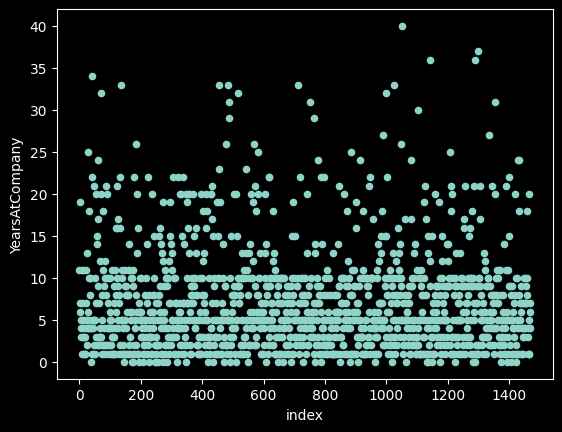

In [10]:
# the lines commented out (except for the one that says "shuffle") will work if you are **not** using cudf
#attrition_df_id = attrition_df.reset_index()
#attrition_df_id.plot(x='index', y='YearsAtCompany', kind='scatter')
# shuffle
#attrition_shuffled = attrition_df.sample(frac=1)
#attrition_shuffled = attrition_shuffled.reset_index(drop=True).reset_index()
#attrition_shuffled.plot(x='index', y='YearsAtCompany', kind='scatter')

#for cudf users, do the following
attrition_df_id = attrition_df.reset_index()[['index', 'YearsAtCompany']].to_pandas()
attrition_df_id.plot(x='index', y='YearsAtCompany', kind='scatter')
# shuffle
attrition_shuffled = attrition_df.sample(frac=1)
attrition_shuffled = attrition_shuffled.reset_index(drop=True).reset_index()[['index', 'YearsAtCompany']].to_pandas()
attrition_shuffled.plot(x='index', y='YearsAtCompany', kind='scatter')

# plot the graphs
plt.show()

- Look at the major skew of the first histogram--it's clearly sorted--where as the second has a much more even distribution: this is the power of random sampling!
---

## **Proportional Stratified Sampling**

---
- If you are interested in subgroups within the population, then you may need to carefully control the counts of each subgroup within the population
- Proportional stratified sampling results in subgroup sizes within the sample that are representative of the subgroup sizes within the population
- It is equivalent to performing a simple random sample on each subgroup

---

### &nbsp;&nbsp;&nbsp;&nbsp; •**Exercise**

---
- First, extract the proportion of employees by their `Education` levels from `attrition_df`
- Print the results

In [11]:
ed_pop_counts = attrition_df['Education'].value_counts(normalize=True)
print(ed_pop_counts)

Education
Bachelor         0.389116
Master           0.270748
College          0.191837
Below_College    0.115646
Doctor           0.032653
Name: proportion, dtype: float64


---
- Use proportional stratified sampling on the variable `ed_pop_counts` to sample 42% of each group in `Education`
- Set the seed to `2025`
- Print the results

In [13]:
attrition_strat = attrition_df.groupby('Education').sample(frac=0.42, random_state=2025)
print(attrition_strat)

      Age  Attrition     BusinessTravel  DailyRate            Department  \
1205   40        0.0      Travel_Rarely        884  Research_Development   
31     26        1.0      Travel_Rarely        471  Research_Development   
478    30        1.0      Travel_Rarely        138  Research_Development   
22     27        0.0         Non-Travel       1450  Research_Development   
104    20        1.0  Travel_Frequently        769                 Sales   
...   ...        ...                ...        ...                   ...   
1195   36        1.0      Travel_Rarely        885  Research_Development   
560    38        0.0      Travel_Rarely        243                 Sales   
1129   54        0.0      Travel_Rarely        397       Human_Resources   
1402   56        0.0      Travel_Rarely        718  Research_Development   
1180   36        0.0      Travel_Rarely        530                 Sales   

      DistanceFromHome Education    EducationField EnvironmentSatisfaction  \
1205     

---
- Now retrieve the proportion of employees from each group within `Education` from `attrition_strat`
- Print the results
- Underneath these results print the results from the `ed_pop_counts` vairable from above, so we can compare how close our sample is to the actual population proportions

In [15]:
attrition_strat_counts = attrition_strat['Education'].value_counts(normalize=True)
print(attrition_strat_counts)
#this print call below is just to create a clear demarcation between the stratified sample proportions and the full population proportions
print('--------------')
print(ed_pop_counts)

Education
Bachelor         0.389610
Master           0.271104
College          0.191558
Below_College    0.115260
Doctor           0.032468
Name: proportion, dtype: float64
--------------
Education
Bachelor         0.389116
Master           0.270748
College          0.191837
Below_College    0.115646
Doctor           0.032653
Name: proportion, dtype: float64


- Everything seems to be in order
 - Great job!

---

## **Equal Counts Stratified Sampling**

---
- If one subgroup is larger than another subgroup in the population, but you don't want to reflect that difference in your analysis,
- then you can use equal counts stratified sampling to generate samples where each subgroup has the same amount of data

---

###  &nbsp;&nbsp;&nbsp;&nbsp; •**Exercise**

---
- Use equal counts stratified sampling on `attrition_df` to get exactly 33 employees from each group within `Education`
- Set the seed to `2025`
- Print the results

In [16]:
attrition_equal = attrition_df.groupby('Education').sample(n=33, random_state=2025)
print(attrition_equal)

      Age  Attrition     BusinessTravel  DailyRate            Department  \
1205   40        0.0      Travel_Rarely        884  Research_Development   
31     26        1.0      Travel_Rarely        471  Research_Development   
478    30        1.0      Travel_Rarely        138  Research_Development   
22     27        0.0         Non-Travel       1450  Research_Development   
104    20        1.0  Travel_Frequently        769                 Sales   
...   ...        ...                ...        ...                   ...   
464    46        0.0         Non-Travel       1144  Research_Development   
624    40        0.0      Travel_Rarely       1322  Research_Development   
619    32        0.0      Travel_Rarely       1373  Research_Development   
911    35        0.0      Travel_Rarely       1224                 Sales   
1390   47        0.0      Travel_Rarely       1176       Human_Resources   

      DistanceFromHome Education    EducationField EnvironmentSatisfaction  \
1205     

---
- Group the proportion of employees by their level of `Education` from `attrition_equal
- Print the results

In [17]:
ed_counts_equal = attrition_equal['Education'].value_counts(normalize=True)
print(ed_counts_equal)

Education
Bachelor         0.2
Below_College    0.2
College          0.2
Doctor           0.2
Master           0.2
Name: proportion, dtype: float64


- Excellent! <br><br>
![Excellent!](notebook_images/excellent-bill-and-ted.gif)

---

## **Weighted Sampling**

---
- Stratified sampling provides rules about the probability of picking rows from your dataset at the subgroup level
- A generalization of this is weighted sampling, which lets you specify rules about the probability of picking rows at the row level
- The probability of picking any given row is proportional to the weight value for that row

---

###  &nbsp;&nbsp;&nbsp;&nbsp; •**Exercise**

---
- Plot the `YearsAtCompany` column from `attrition_df` as a histogram of bins with width equal to `1`, ranging from `0`to `40`
- Make sure to show the result &#128517;

In [6]:
# If you are **not** using cudf and just regular pandas, then the commented code below will work
#attrition_df['YearsAtCompany'].hist(bins=np.arange(0, 41, 1))
#plt.show()

# If you are using cudf, then you can make a histogram this way
plt.hist(attrition_df['YearsAtCompany'], bins=np.arange(0, 41, 1))
plt.show()

E1216 14:00:32.145568  115806 cuda_dnn.cc:456] Loaded runtime CuDNN library: 9.10.2 but source was compiled with: 9.12.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E1216 14:00:32.150513  115806 cuda_dnn.cc:456] Loaded runtime CuDNN library: 9.10.2 but source was compiled with: 9.12.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.


JaxRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

---
- Import pandas and include the pandas version for creating an unweighted sample histogram (the second line of the cell) from above--we will plot it again with a weighted histogram and compare the results
- Sample `444` employees from `attrition_df` weighted by the `YearsAtCompany` column
- Use seed `2025`
- Plot the weighted sample of the `YearsAtCompany` column from `attrition_df_pd`* as a histogram with width equal to `1`, ranging from `0` to `40`
- Make sure to show the result &#128517;
- *Unfortunately, at the time of creating this notebook, there are problems with doing weighted sampling in cudf, so we will use pandas here exclusively, thus we will create a new DataFrame variable called `attrition_df_pd`
- **<u>NOTE</u>**: if you are only using pandas you do **not** need to reimport pandas nor create the new DataFrame `attrtition_df_pd`

In [12]:
# import and non-weighted sample histogram
import pandas as pd
attrition_df['YearsAtCompany'].hist(bins=np.arange(0, 41, 1))

#weighted sample histogram
attrition_df_pd = pd.read_parquet('~/000_Duckspace/Learning/DataScience/Python_DataScience_Examples/data/sampling/attrition.parquet')
attrition_weighted = attrition_df_pd.sample(n=444, weights='YearsAtCompany', random_state=2025)
attrition_weighted['YearsAtCompany'].hist(bins=jnp.arange(0, 41, 1))

# plot them both
plt.show()

AttributeError: 'Series' object has no attribute 'hist'

- Nice!
- Notice how the weighted sample graph skews towards the right vs the non-weighted graph we made before

---

## **Cluster Sampling**

---
- Stratified sampling requires all subgroups to be used, but this may not be the best route if gathering data for every subgroup is extremely difficult/expensive; this is where cluster sampling can help
- Cluster sampling is a two-stage sampling technique that is closely related to stratified sampling. First, you randomly sample which subgroups to include in the sample, then randomly sample rows within each subgroup.

---
#### **<u>Stratified Sampling vs. Cluster Sampling</u>**
- **Stratified Sampling**
    - Splits population into subgroups
    - Then uses simple random sampling on every subgroup
- **Cluster Sampling**
    - Uses simple random sampling to select some subgroups
    - Then uses simple random sampling on only those selected subgroups

---

###  &nbsp;&nbsp;&nbsp;&nbsp; • Exercise

---
- Create a list of the unique values in the `JobRole` column of `attrition_df` and assign to `job_roles`
- Randomly sample `6` roles from `job_roles_sample`
- Print the results

In [4]:
# use this if you are **not** using cudf
#job_roles = list(attrition_df['JobRole'].unique())
#job_roles_sample = random.sample(job_roles, k=6)
#print(job_roles_sample)

# use this if you are using cudf
job_roles = attrition_df['JobRole'].to_pandas().unique().tolist()
job_roles_sample = random.sample(job_roles, k=6)
print(job_roles_sample)

['Manager', 'Research_Director', 'Healthcare_Representative', 'Research_Scientist', 'Human_Resources', 'Laboratory_Technician']


 ---
  - Select rows with `job_roles_sample`, then filter for rows where values in the `JobRole` column are roles in the `job_roles_sample` list and assign selection to `job_roles_selected` and filtered to `attrition_filtered`
- Remove any unused categories from the filtered DataFrame (NOTE: ensure the `JobRole` column is of type `category`)
- Randomly sample `13` employees from `attrition_filtered`and assign to `attrition_cluster`
- Use seed `2025`
- Print the results

In [10]:
# Select
job_roles_selected = attrition_df['JobRole'].isin(job_roles_sample)
# Filter
attrition_filtered = attrition_df[job_roles_selected]
# Remove categories
attrition_filtered['JobRole'] = attrition_filtered['JobRole'].astype('category')
# in pandas you can use this if you want to remove unused categories; however, see "# Random sampling" below for a simpler way
#attrition_filtered['JobRole'] = attrition_filtered['JobRole'].cat.remove_unused_categories()

# Random sampling---NOTE: use "observed=True" in the ".groupby()" method to ignore unused categories
attrition_cluster = attrition_filtered.groupby('JobRole', observed=True).sample(n=13, random_state=2025)
print(attrition_cluster)

      Age  Attrition     BusinessTravel  DailyRate            Department  \
562    40        0.0  Travel_Frequently        791  Research_Development   
407    29        0.0  Travel_Frequently        995  Research_Development   
867    35        0.0      Travel_Rarely        670  Research_Development   
1130   35        0.0         Non-Travel       1225  Research_Development   
1104   38        0.0      Travel_Rarely        833  Research_Development   
...   ...        ...                ...        ...                   ...   
420    27        0.0      Travel_Rarely       1054  Research_Development   
916    35        0.0      Travel_Rarely       1395  Research_Development   
371    25        0.0      Travel_Rarely        180  Research_Development   
195    31        1.0         Non-Travel        335  Research_Development   
372    35        0.0      Travel_Rarely       1343  Research_Development   

      DistanceFromHome      Education EducationField EnvironmentSatisfaction  \
562    

- Looks good!

---


###  &nbsp;&nbsp;&nbsp;&nbsp; • Exercise


---
##### Let's compare a calculation made on the entire population versus our these three methods of sampling (simple random sampling, stratified sampling, and cluster sampling) side-by-side

---
<br><br>
- For the **full population**:
    1. Group `attrition_df`by the `RelationshipSatisfaction` column, which categorizes the employee's relationship with the company. It has four levels: `Low`, `Medium`, `High`, and `Very_High`
    2. Subset this by the `Attrition` column, which is either `0`(meaning the employee has not left the company) or `1` (meaning the employee has left the company)
    3. Calculate the `.mean()` of the `Attrition` column for every individual within each satisfaction level, save this to the variable `atrrition_full_mean`
<br><br>
- For the **simple random sample**:
    1. Take a simple random sample consisting of `333` employees from `attrition_df`, set the seed to `69420`, and save this to the variable `attrition_srs`
    2. Group `attrition_srs`by the `RelationshipSatisfaction` column, subset this by the `Attrition` column
    3.  Calculate the `.mean()` of the `Attrition` column for every individual of the sample within each satisfaction level, save this to the variable `attrition_srs_mean`
<br><br>
- For the **stratified sample**:
    1. Take a stratified sample from `22.2%` of employees within each subgroup of `RelationshipSatisfaction`, set the seed to `69420`, and save this to the variable `attrition_strat`
    2. Group `attrition_srs`by the `RelationshipSatisfaction` column, subset this by the `Attrition` column
    3. Calculate the `.mean()`of the `Attrition` column for every individual of the sample within each satisfaction level, save this to the variable `attrition_strat_mean`
<br><br>
- For the **cluster sample**:
    1. Store the unique values of the `RelationshipSatisfaction` column as `relationship_satisfactions`, then take a sample of `3` subgroups from `relationship_satisfactions` and store as `relationship_satisfactions_sample`
    2. Select only the rows within `attrition_df` where the `RelationshipSatisfaction` value is one of the values sampled and store as `relationship_satisfactions_selected`, then filter `attrition_df` for these selected rows, saving as `attrition_rel_sat_filtered`and ensure the values in the `RelationshipSatisfaction` column are type `category`
    3. Randomly sample `111` employees from each of the sampled subgroups and save to the variable `attrition_rel_sat_cluster`
    4. Calculate the `.mean()` of the `Attrition` column for the sampled individuals from the sampled satisfaction levels, save this to the variable `attrition_rel_sat_mean`
<br><br>
- Lastly, print all the results, so we can view them all together and compare

In [22]:
# full population
attrition_full_mean = attrition_df.groupby('RelationshipSatisfaction')['Attrition'].mean()

# simple random sampling
attrition_srs = attrition_df.sample(n=333, random_state=69420)
attrition_srs_mean = attrition_srs.groupby('RelationshipSatisfaction')['Attrition'].mean()

# stratified random sampling
attrition_strat = attrition_df.groupby('RelationshipSatisfaction').sample(frac=0.222, random_state=69420)
attrition_strat_mean = attrition_strat.groupby('RelationshipSatisfaction')['Attrition'].mean()

# cluster sampling
relationship_satisfactions = attrition_df['RelationshipSatisfaction'].to_pandas().unique().tolist()
relationship_satisfactions_sample = random.sample(relationship_satisfactions, k=3)
relationship_satisfactions_selected = attrition_df['RelationshipSatisfaction'].isin(relationship_satisfactions_sample)
attrition_rel_sat_filtered = attrition_df[relationship_satisfactions_selected]
attrition_rel_sat_filtered['RelationshipSatisfaction'] = attrition_rel_sat_filtered['RelationshipSatisfaction'].astype('category')
attrition_rel_sat_cluster = attrition_rel_sat_filtered.groupby('RelationshipSatisfaction', observed=True).sample(n=111, random_state=69420)
attrition_rel_sat_cluster_mean = attrition_rel_sat_cluster.groupby('RelationshipSatisfaction')['Attrition'].mean()

# print -> this print call is formatted to make the output means easier to read and compare
print(
    f"\033[1;4mFull\033[0m:\n{attrition_full_mean}\n"
    f"---------------------------------------------------------------------\n\n"
    f"\033[1;4mSimple\033[0m:\n{attrition_srs_mean}\n"
    f"---------------------------------------------------------------------\n\n"
    f"\033[1;4mStratified\033[0m:\n{attrition_strat_mean}\n"
    f"---------------------------------------------------------------------\n\n"
    f"\033[1;4mCluster\033[0m:\n{attrition_rel_sat_cluster_mean}"
)

Full:
RelationshipSatisfaction
High         0.154684
Low          0.206522
Medium       0.148515
Very_High    0.148148
Name: Attrition, dtype: float64
---------------------------------------------------------------------

Simple:
RelationshipSatisfaction
High         0.184466
Low          0.227273
Medium       0.184615
Very_High    0.121212
Name: Attrition, dtype: float64
---------------------------------------------------------------------

Stratified:
RelationshipSatisfaction
High         0.225490
Low          0.245902
Medium       0.194030
Very_High    0.156250
Name: Attrition, dtype: float64
---------------------------------------------------------------------

Cluster:
RelationshipSatisfaction
Low          0.216216
Medium       0.153153
Very_High    0.117117
Name: Attrition, dtype: float64


- **Super Duper!**
<br><br>
![Super Duper!](notebook_images/anchorman-that's-nice.gif)
<br><br>
- **<u>That's Nice!</u>**
---